# Google Cloud Public Datasets Program
## Understanding the Impact of Hurricanes on Retail Supply Chains


Imagine that you are a retailer who is looking to expand your supply chain. You are specifically looking for something along the US coast to take advantage of its proximity to large population centers that could be the home of your next customers and the numerous ports along the coast. Given that Atlantic hurricane activity has increased since the 1970s, you will need to understand how severe storms, specifically hurricanes, could potentially disrupt your supply chain before deciding where to place your next warehouse.

This demo analyzes [hurricane data produced by NOAA](https://console.cloud.google.com/marketplace/details/noaa-public/hurricanes) available through the Google Cloud Public Datasets Program can help you better understand and prepare for the risk that hurricanes present to your business. The analysis uses [BigQuery Geographic Information Systems (GIS)](https://cloud.google.com/bigquery/docs/gis-intro) to combine the hurricane data with [US urban area boundary data](https://console.cloud.google.com/marketplace/details/united-states-census-bureau/us-geographic-boundaries) also available through the Cloud Public Datasets Program. The urban area data is one of more than 10 datasets available in BigQuery that define boundaries in the US, including states, zip codes, counties, and more.

To see the entire catalog of datasets available through the Google Cloud Public Datasets Program, check out [GCP Marketplace](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset&q=public%20dataset). To learn more about the Google Cloud Public Datasets Program, see our [landing page](https://cloud.google.com/public-datasets).


     

## Before you begin

1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery APIs](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) for the project.

This is the basic setup for Colab use. You should only need to do this once to get started. If you have more questions about setting this, check out either Colab's [Welcome to Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook or [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb) notebook.

### Provide your credentials to the runtime

This authenticates your account so that you can save notebooks for the future.

In [ ]:
! gcloud auth login

Authenticated


## Using BigQuery's Client Library
There are multiple means to work with BigQuery while using Colaboratory, including through magics and `pandas-gbq`. This example will work through the BigQuery Python client (`google-cloud-bigquery`). If you want more information on working through magics, see the [library reference documentation](https://googleapis.github.io/google-cloud-python/latest/bigquery/magics.html). For an example, see the [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb) notebook.

### How to use BigQuery through BigQuery Python client library

#### Resources and documentation:
See the following resources for more information about using the `google-cloud-bigquery` library.

*   [API methods table](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client)
*  [BigQuery documentation](https://cloud.google.com/bigquery/docs)
*  [Library reference documentation](https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/usage.html)

### Getting Setup
The first step is to declare the cloud project ID which will be used. This set the GCP project that is used throughout the notebook.

If you decide to change projects, make sure you come back to this step to replace the project id. If you reauthenticate, or disconnect from your runtime, make sure you come back to this step to run this cell again.


In [ ]:
project_id = 'cloud-public-datasets-demos'

We'll follow by installing the plotnine library and it's dependencies. This is a visualization library similar to the  ```ggplot2``` library widely popular among R users thanks to its ability to quickly and consistently develop useful data visualizations. You should only need to do this once as well.

If you are looking for a more user-friendly interface to create and easily share visualizations, check out [Google Data Studio](https://datastudio.google.com).



In [ ]:
%pip install 'plotnine[all]'

     |████████████████████████████████| 9.2MB 2.7MB/s 


Next, we'll import the `google-cloud-bigquery` library, as well as a few others. For convenience, Colabs already has the Google Cloud Client Libraries necessary for calling Google Cloud APIs already installed. We'll bring in a few others to help aid our analysis, and set a variable to reduce the length of our query calls through the API.

If you change projects, reauthenticate, or disconnect from your runtime, make sure you come back to this step to run this cell again.

In [ ]:
from google.cloud import bigquery
from plotnine import *
import numpy as np
from numpy import *
import pandas as pd

client = bigquery.Client(project = project_id)


## Examining historical hurricane activity in the Atlantic
WIth the set-up complete, we can begin our analysis. For this example, let's assume you open to any US city in the Southeast for your next warehouse, which is why hurricanes might be a concern. Let's start with a simple ```select all``` statement for hurricanes in the North Atlantic basin to get started. This gives us an opportunity to review the dataset's structure and the available variables. You can also do this by viewing the table in the [BigQuery Console UI](https://pantheon.corp.google.com/bigquery?p=bigquery-public-data&d=noaa_hurricanes&t=hurricanes&page=table) and clicking "preview".

To see the entire history, remove <code>.head()</code> from the end of the statement, then run the cell.

In [ ]:
# Perform a query.
historic_hurricane_query = """
SELECT
  *
FROM
  `bigquery-public-data.noaa_hurricanes.hurricanes` as h
WHERE
  basin = "NA"
    """
historic_hurricane = client.query(historic_hurricane_query).to_dataframe()

historic_hurricane.head()


,sid,season,number,basin,subbasin,name,iso_time,nature,latitude,longitude,wmo_wind,wmo_pressure,wmo_agency,track_type,dist2land,landfall,iflag,usa_agency,usa_latitude,usa_longitude,usa_record,usa_status,usa_wind,usa_pressure,usa_sshs,usa_r34_ne,usa_r34_se,usa_r34_sw,usa_r34_nw,usa_r50_ne,usa_r50_se,usa_r50_sw,usa_r50_nw,usa_r64_ne,usa_r64_se,usa_r64_sw,usa_r64_nw,usa_poci,usa_roci,usa_rmw,...,bom_roci,bom_poci,bom_eye,bom_pos_method,bom_pressure_method,wellington_latitude,wellington_longitude,wellington_wind,wellington_pressure,nadi_latitude,nadi_longitude,nadi_cat,nadi_wind,nadi_pressure,ds824_latitude,ds824_longitude,ds824_stage,ds824_wind,ds824_pressure,td9636_latitude,td9636_longitude,td9636_stage,td9636_wind,td9636_pressure,td9635_latitude,td9635_longitude,td9635_wind,td9635_pressure,td9635_roci,neumann_latitude,neumann_longitude,neumann_class,neumann_wind,neumann_pressure,mlc_latitude,mlc_longitude,mlc_class,mlc_wind,mlc_pressure,usa_atcf_id
0,2018267N33314,2018,70,NA,NA,LESLIE,2018-09-26 12:00:00+00:00,NR,33.7468,-40.0305,NaN,NaN,,PROVISIONAL,1814,1719.0,I_____________,tcvitals,33.7468,-40.0305,,,57.0,986.0,0.0,191.0,219.0,277.0,460.0,NaN,NaN,111.0,134.0,NaN,NaN,NaN,NaN,1013.0,383.0,88.0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,,NaN,NaN,AL132018
1,2018246N22283,2018,61,NA,NA,GORDON,2018-09-06 06:00:00+00:00,NR,33.5131,-90.9543,NaN,NaN,,PROVISIONAL,0,0.0,I_____________,tcvitals,33.5131,-90.9543,,,28.0,1013.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1015.0,86.0,23.0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,,NaN,NaN,AL072018
2,2018246N22283,2018,61,NA,NA,GORDON,2018-09-06 18:00:00+00:00,NR,34.4372,-91.6335,NaN,NaN,,PROVISIONAL,0,0.0,I_____________,tcvitals,34.4372,-91.6335,,,32.0,1013.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1016.0,121.0,23.0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,,NaN,NaN,AL072018
3,2018267N33314,2018,70,NA,NA,LESLIE,2018-09-25 18:00:00+00:00,NR,32.5512,-44.0316,NaN,NaN,,PROVISIONAL,1742,1717.0,I_____________,tcvitals,32.5512,-44.0315,,,32.0,1004.0,-1.0,NaN,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1015.0,356.0,138.0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,,NaN,NaN,AL132018
4,2018267N33314,2018,70,NA,NA,LESLIE,2018-09-26 18:00:00+00:00,NR,36.0202,-39.8998,NaN,NaN,,PROVISIONAL,1613,1524.0,I_____________,tcvitals,36.0202,-39.8998,,,60.0,979.0,0.0,268.0,230.0,277.0,506.0,NaN,NaN,176.0,222.0,NaN,NaN,NaN,NaN,1013.0,421.0,130.0,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,,None,None,NaN,NaN,,NaN,NaN,AL132018


You'll notice that each row reports a different location (indicated by latitude and longitude) and a different timestamp, though the storm name or unique ID (``sid``) may be repeated. This allows us to see the exact location at a given time for a specified storm and makes it possible for us to plot the exact path of each storm.

You will also notice that there are a lot of variables in this dataset. This is because the dataset provides the location of the storm's center, as measured by many of the world's meteorological agencies such as those in the US and Japan. These measurements can have slightly differing values for many reasons, but any difference are adressed when the observations are aggregated into a single value each for latitude and longitude. The resulting variables (latitude and longitude) represent the internationally agreed upon location of the storm's center at the specified time. For our purposes, we'll focus on that location and ignore the others.  

In [ ]:
client = bigquery.Client(project = project_id)

# Perform a query.
sales_by_month_query = """
    SELECT
      store_name as store,
      DATE_TRUNC(date, MONTH) as month,
      item_description,
      SUM(bottles_sold) as bottles_sold,
      ROUND(SUM(sale_dollars),2) as sale_dollars
    FROM
      `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
      store_name = "Cyclone Liquors"
    GROUP BY
      item_description,
      month,
      store
    ORDER BY sale_dollars desc
    """

sales_by_month = client.query(sales_by_month_query).to_dataframe()

sales_by_month.head()


,store,month,item_description,bottles_sold,sale_dollars
0,Cyclone Liquors,2018-04-01,Jack Daniels Single Barrel Personal Collection...,342,16662.24
1,Cyclone Liquors,2018-11-01,Makers Mark Private Select,246,12915.00
2,Cyclone Liquors,2017-09-01,Jack Daniel's Single Barrel Buy the Barrel,300,12192.00
3,Cyclone Liquors,2019-02-01,Blantons Buy the Barrel,264,11386.32
4,Cyclone Liquors,2013-01-01,Templeton Rye,360,9766.80


## Predicting the impact of weather on sales
### Connecting weather and sales data

Based on this breakdown, you notice that different liquors tend to sell better in different months, but the patterns aren't identical across every year. Because you order inventory on a monthly basis, it would be helpful to fully understand what causes this trend. You decide to look into the impact of weather on your sales, and decide to use [NOAA's Global Historical Climatology Network (GHCN)](https://console.cloud.google.com/marketplace/details/noaa/noaa-ghcn), which is also available as a BigQuery Public Dataset. NOAA's GHCN provides weather observations from more than 11,000 stations around the world and is quality-controlled by NOAA's data steward experts.

In [ ]:
client = bigquery.Client(project = project_id)

# Find the store's location
store_point_query = """
    SELECT
      store_name,
      zip_code,
      store_location
    FROM
      `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
      store_name = "Cyclone Liquors"
      AND store_location is NOT NULL
    LIMIT 1
    """

store_point = client.query(store_point_query)

rows = store_point.result()

# Store the location as a variable
for row in rows:
    store_geom = row.store_location
    print(store_geom)

POINT (-93.618911 42.022854)


Now that we have the geographic location of the store, we can use that to find the closest weather stations.

In [ ]:
client = bigquery.Client(project = project_id)

#Modify these variables to adapt the query to fit your needs, including how the maximum distance to a station, and the maximum number of stations
maxcount_stations = 10
max_dist_km = 50

station_distance_query_params = [
  bigquery.ScalarQueryParameter("store_location", "STRING", store_geom),
  bigquery.ScalarQueryParameter("maxcount_stations", "INT64", maxcount_stations),
  bigquery.ScalarQueryParameter("maxdist_meters", "NUMERIC", max_dist_km * 1000)
]
station_distance_query = """
  WITH params as(
    SELECT
      ST_GeogFromText(store_location) as store_loc,
#Be sure to set the maximum distance (in kilometers) for weather stations to match your query
      50 as maxdist_km
    FROM
      `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
      store_location = @store_location
  ),
 distance_from_store as(
    SELECT
      DISTINCT(id) as station_id,
      name,
      state,
      ROUND(ST_Distance(ST_GeogPoint(s.longitude, s.latitude), p.store_loc)/1000, 4) AS dist_km
    FROM
      `bigquery-public-data.ghcn_d.ghcnd_stations` s,
      params p
    WHERE
      ST_DWithin(ST_GeogPoint(s.longitude, s.latitude), store_loc, @maxdist_meters) = TRUE
      AND s.state IS NOT NULL
  )

  SELECT
    DISTINCT(station_id) as station_id,
    name as station_name,
    state,
    dist_km
  FROM
    distance_from_store
  GROUP BY
    station_id,
    name,
    state,
    dist_km
  ORDER BY
    dist_km asc
#Be sure to set the maximum number of stations you wish to see here
  LIMIT
    @maxcount_stations
"""



job_config = bigquery.QueryJobConfig()
job_config.query_parameters = station_distance_query_params

station_distances = client.query(station_distance_query,job_config).to_dataframe()


closest_station_name = station_distances.iloc[5,1]
closest_station_id = station_distances.iloc[5,0]

station_distances.head(maxcount_stations)


,station_id,station_name,state,dist_km
0,US1IASR0017,AMES 0.9 ENE,IA,1.0277
1,USC00130209,AMES EXP STN,IA,1.3203
2,US1IASR0031,AMES 1.2 NNE,IA,1.7375
3,US1IASR0002,AMES 1.5 NNE,IA,2.4435
4,US1IASR0021,AMES 2.0 N,IA,3.2506
5,USW00094989,AMES MUNI AP,IA,3.4164
6,US1IASR0012,AMES 2.1 N,IA,3.5663
7,USC00130205,AMES 3 SW,IA,3.6132
8,US1IASR0005,AMES 2.6 NNW,IA,4.4369
9,US1IASR0029,AMES 2.5 W,IA,4.5781


This allows you to see the 10 GHCN weather stations closest to the store location we determed earlier (<code>store geom</code>). While there are closer stations, we'll use the station at the airport (AMES MUNI AP) since it is likely to have the most complete data.We'll start by writing the station_id for the "optimal" station to a variable so it's easier to work with later on.

Now that we have selected a station, let's do a quick sanity check to make sure this station has been in use long enough to support our analysis.

In [ ]:
check_params = [
  bigquery.ScalarQueryParameter("closest_station_id", "STRING", closest_station_id)
]

operational_check_query = """
  SELECT
    id,
    element,
    firstyear,
    lastyear
  FROM
     `bigquery-public-data.ghcn_d.ghcnd_inventory`
  WHERE
    id = @closest_station_id
"""

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = check_params

operational_check = client.query(operational_check_query,job_config).to_dataframe()

operational_check.head(10)

,id,element,firstyear,lastyear
0,USW00094989,TMAX,1996,2019
1,USW00094989,TMIN,1996,2019
2,USW00094989,PRCP,1998,2019
3,USW00094989,SNOW,2012,2019
4,USW00094989,SNWD,1998,2019
5,USW00094989,AWND,1998,2019
6,USW00094989,FMTM,1998,2005
7,USW00094989,PGTM,1998,2018
8,USW00094989,TAVG,1998,2005
9,USW00094989,TSUN,1999,2005


### Visualizing sales peaks and temperature

It looks like this station has exactly the time period of data we need, so we can continue. Let's start with the store's average weather over the last 10 years.  We'll start with a plot of the by-month average of temperature and total sales to make it easier for us to manually review.

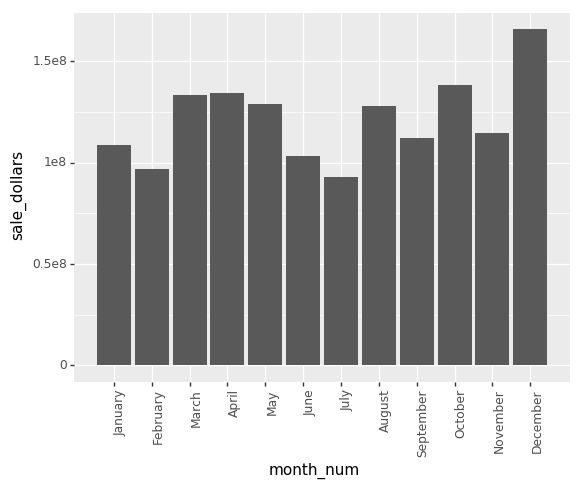

<ggplot: (8752954332301)>

In [ ]:
query_params = [
  bigquery.ScalarQueryParameter("store_location", "STRING", store_geom),
  bigquery.ScalarQueryParameter("maxcount_stations", "INT64", maxcount_stations),
  bigquery.ScalarQueryParameter("closest_station_id", "STRING", closest_station_id)
]
store_weather_query = """
with weather_obs AS (
  SELECT
    wx.date AS date,
    IF (wx.element = 'PRCP', (wx.value/10)/25.4, IF (wx.element = 'SNOW', (wx.value/10)/25.4, NULL)) AS prcp,
    IF (wx.element = 'TMIN', (wx.value/10)*(9/5)+32, NULL) AS tmin,
    IF (wx.element = 'TMAX', (wx.value/10)*(9/5)+32, NULL) AS tmax
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_*` AS wx
  WHERE
    id = @closest_station_id
    AND _TABLE_SUFFIX BETWEEN CAST((EXTRACT(YEAR from CURRENT_DATE())-10) AS STRING) AND CAST(EXTRACT(YEAR from CURRENT_DATE()) AS STRING)
)
SELECT
    EXTRACT(MONTH FROM w.date) as month_num,
    FORMAT_DATE('%B', DATE_TRUNC(w.date, MONTH)) as month_name,
--    l.item_description as item_name,
    ROUND(AVG(prcp),2) AS prcp,
    ROUND(AVG(tmin),2) AS tmin,
    ROUND(AVG(tmax),2) AS tmax,
    SUM(l.bottles_sold) as bottles_sold,
    ROUND(SUM(sale_dollars),2) as sale_dollars
FROM
  weather_obs w
  JOIN
    `bigquery-public-data.iowa_liquor_sales.sales` l on DATE_TRUNC(w.date, MONTH) = DATE_TRUNC(l.date, MONTH)
WHERE
  store_name = "Cyclone Liquors"
GROUP BY
--  item_name,
  month_name
  ,month_num
HAVING tmin > -100 AND tmax > -100
ORDER BY
  month_num
"""

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params

monthly_weather_sales = client.query(store_weather_query,job_config).to_dataframe()
monthly_weather_sales.head(12)

months =  array(monthly_weather_sales.month_name)
month_numbers = array(monthly_weather_sales.month_num)

(ggplot(monthly_weather_sales)
+aes('month_num', 'sale_dollars')
+geom_bar(stat="identity")
+theme(axis_text_x=element_text(rotation=90, hjust=0))
+scale_x_discrete(labels = months, limits = months)
)

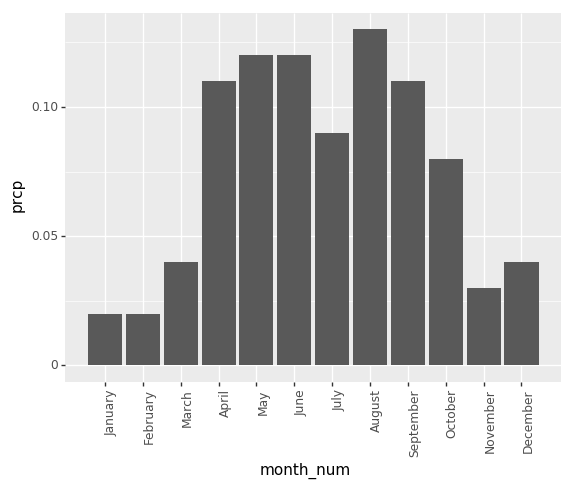

<ggplot: (-9223363283900549979)>

In [ ]:
(ggplot(monthly_weather_sales)
+aes('month_num', 'prcp')
+geom_bar(stat="identity")
+theme(axis_text_x=element_text(rotation=90, hjust=0))
+scale_x_discrete(labels = months, limits = months)
)

<p>We can clearly see a seasonal trend above, where stores purchase more alcohol in advance of major holidays, and in the spring. Keep in mind the <code>liquor sales</code> dataset reflects <i>wholesale</i> purchase, not individual purchase. So this either a lagging indicator as stores are restocking after heavy purchasing periods, or a leading indicator where stores are adding inventory in expectation of future sales. </p>

  ---
### Building the model

<p>But we can better understand the seasonal impact on individual products using the same weather data thanks to BigQuery Machine Learning (BQML). If you aren't familiar with BQML, it allows users to create and run ML models using SQL. For more details, see the <a href = "https://cloud.google.com/bigquery-ml/docs/bigqueryml-intro">BQML documentation</a>. </p>
<p>We'll get started by creating a model that randomly divides the data into training and evaluation data using the "random" data split feature in BigQuery. We'll create a model that predicts the number of bottles sold for each product so retailers can more accurately stock their stores.
  
  <b>Note</b>: This model processes more than 15 GBs of data, so it will take some time to run. Once it is created, you will see the statement <code> model complete!</code> printed in the notebook. In the meantime, feel free to change tabs or get a cup of coffee.

In [ ]:
create_model_query_params = [
  bigquery.ScalarQueryParameter("store_location", "STRING", store_geom),
  bigquery.ScalarQueryParameter("maxcount_stations", "INT64", maxcount_stations),
  bigquery.ScalarQueryParameter("closest_station_id", "STRING", closest_station_id)
]

create_model_query = """
#Be sure to replace the project and model name below to your project!

#Be sure to replace the project and model name below to your project!
CREATE OR REPLACE MODEL `cloud-public-datasets-demos.retail_demo.sales_and_weather`
OPTIONS(
  model_type='linear_reg',
  data_split_method = 'random',
  data_split_eval_fraction = 0.3,
  input_label_cols = ['bottles_sold']) AS
    SELECT
        l.* EXCEPT (date, invoice_and_item_number),
        wx.* EXCEPT (element, date),
        IF (wx.element = 'PRCP', (wx.value/10)/25.4, NULL) AS prcp,
        IF (wx.element = 'SNOW', (wx.value/10)/25.4, NULL) as snow,
        IF (wx.element = 'TMIN', (wx.value/10)*(9/5)+32, NULL) AS tmin,
        IF (wx.element = 'TMAX', (wx.value/10)*(9/5)+32, NULL) AS tmax,
        EXTRACT(MONTH from wx.date) AS month
      FROM
        `bigquery-public-data.ghcn_d.ghcnd_*` wx
      JOIN
        `bigquery-public-data.iowa_liquor_sales.sales` l on l.date = wx.date
      WHERE
        id = "USW00094989"
        AND store_name = "Cyclone Liquors"
        AND wx._TABLE_SUFFIX BETWEEN CAST((EXTRACT(YEAR from CURRENT_DATE())-10) AS STRING) AND CAST(EXTRACT(YEAR from CURRENT_DATE()) AS STRING)
      """

query_job_config = bigquery.QueryJobConfig()
job_config.query_parameters = create_model_query_params

create_sales_model = client.query(create_model_query,query_job_config)

rows = create_sales_model.result()

print("Model Complete!")


Model Complete!


Now that the model is complete (and you have a fresh cup of coffee), let's take a quick look at the information about the model's training iterations. We should expect to see the <code>loss</code> column decrease as the iteration count increases.

In [ ]:
training_info_query = """
SELECT
  *
FROM
#Be sure to replace the model name below with your own model name
  ML.TRAINING_INFO(MODEL `cloud-public-datasets-demos.retail_demo.sales_and_weather`)
"""

training_info=client.query(training_info_query).to_dataframe()

training_info.head(20)

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,0,2.041682,2.016414,111068,None


### Evaluating the model

With that complete, we can now fully evaluate the model. The most important metrics to evaluate for linear regression models is r2_score.

r2_score is a statistical measure that determines how well predictions approximate the actual data. A score of 0 indicates that the model explains none of the variability of the response data around the mean. A score of 1 indicates the model completely explains all variability of the response data around the mean of the data, though this may indicate the model is overfitted to the training data.

In [ ]:
model_eval_query = """
SELECT
  *
FROM
#Be sure to replace the model name below with your own model name
  ML.EVALUATE(MODEL `cloud-public-datasets-demos.retail_demo.sales_and_weather`,
    (SELECT
        l.* EXCEPT (date, invoice_and_item_number),
        wx.* EXCEPT (element, date),
        IF (wx.element = 'PRCP', (wx.value/10)/25.4, NULL) AS prcp,
        IF (wx.element = 'SNOW', (wx.value/10)/25.4, NULL) as snow,
        IF (wx.element = 'TMIN', (wx.value/10)*(9/5)+32, NULL) AS tmin,
        IF (wx.element = 'TMAX', (wx.value/10)*(9/5)+32, NULL) AS tmax,
        EXTRACT(MONTH from wx.date) AS month
      FROM
        `bigquery-public-data.ghcn_d.ghcnd_*` wx
      JOIN
        `bigquery-public-data.iowa_liquor_sales.sales` l on l.date = wx.date
      WHERE
        id = "USW00094989"
        AND store_name = "Cyclone Liquors"
        AND wx._TABLE_SUFFIX BETWEEN CAST((EXTRACT(YEAR from CURRENT_DATE())-10) AS STRING) AND CAST(EXTRACT(YEAR from CURRENT_DATE()) AS STRING)
        )
  )
"""

model_eval=client.query(model_eval_query).to_dataframe()

model_eval.head()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.463555,2.034084,0.029031,0.196895,0.934683,0.934683



It looks like we have a pretty effective model!

### Implementing the model

This means the model is ready to be run and predict the number of bottles sold for each product. In this case we'll limit the model prediction to the months of November and December so that we can make a more informed ordering decision for upcoming inventory purchases during the store's busiest month.

In [ ]:
model_predict_query_params = [
  bigquery.ScalarQueryParameter("start_month_number", "INT64", 11),
  bigquery.ScalarQueryParameter("end_month_number", "INT64", 12)

]

model_predict_query = """

with savings as(
  SELECT
    item_description,
    p.predicted_bottles_sold as predicted_bottles_sold,
    month
FROM
#Be sure to replace the model name below with your own model name
  ML.PREDICT(MODEL `cloud-public-datasets-demos.retail_demo.sales_and_weather`,
    (SELECT
        l.* EXCEPT (bottles_sold, date, invoice_and_item_number),
        wx.* EXCEPT (element, date),
        IF (wx.element = 'PRCP', (wx.value/10)/25.4, NULL) AS prcp,
        IF (wx.element = 'SNOW', (wx.value/10)/25.4, NULL) as snow,
        IF (wx.element = 'TMIN', (wx.value/10)*(9/5)+32, NULL) AS tmin,
        IF (wx.element = 'TMAX', (wx.value/10)*(9/5)+32, NULL) AS tmax,
        EXTRACT(MONTH from wx.date) AS month
      FROM
        `bigquery-public-data.ghcn_d.ghcnd_*` wx
      JOIN
        `bigquery-public-data.iowa_liquor_sales.sales` l on l.date = wx.date
      WHERE
        id = "USW00094989"
        AND EXTRACT(MONTH from wx.date) BETWEEN @start_month_number AND @end_month_number
        AND store_name = "Cyclone Liquors"
        AND wx._TABLE_SUFFIX BETWEEN CAST((EXTRACT(YEAR from CURRENT_DATE())-10) AS STRING) AND CAST(EXTRACT(YEAR from CURRENT_DATE()) AS STRING)
      )
   ) p
)
SELECT
  ROUND((SUM(l.bottles_sold) * AVG(state_bottle_retail)),2) as real_inventory_cost,
  ROUND((SUM(predicted_bottles_sold) * AVG(state_bottle_retail)),2) as predicted_inventory_cost,
  ROUND((SUM(l.bottles_sold) * AVG(state_bottle_retail)) - (SUM(predicted_bottles_sold) * AVG(state_bottle_retail)),2) as predicted_inventory_savings,
  ROUND(((SUM(l.bottles_sold) * AVG(state_bottle_retail)) - (SUM(predicted_bottles_sold) * AVG(state_bottle_retail)))/(SUM(l.bottles_sold) * AVG(state_bottle_retail))*100,3) as percent_cost_savings
FROM
  savings p
JOIN
 `bigquery-public-data.iowa_liquor_sales.sales` l USING (item_description)
WHERE
  EXTRACT(MONTH from l.date) BETWEEN @start_month_number AND @end_month_number
  AND store_name = "Cyclone Liquors"
  AND p.month BETWEEN @start_month_number AND @end_month_number
"""

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = model_predict_query_params

monthly_weather_sales = client.query(model_predict_query,job_config).to_dataframe()
monthly_weather_sales.head()

,real_inventory_cost,predicted_inventory_cost,predicted_inventory_savings,percent_cost_savings
0,2.245179e+08,2.203661e+08,4151778.04,1.849


## Recap

Looking at our results, the model could have a huge positive impact. With a cost savings of 1.85%, we are able to save more than $4 million by making sure we are ordering the inventory that customers are most likely to purchase.

We used weather data from the [Google Cloud Public Datasets Program](https://cloud.google.com/public-datasets/), to analysis our company's existing sales data to build a machine learning model that provided new insights into our existing datasets and saved our business money. We didn't have to discover, access, or onboard the dataset. We simply joined data already available in BigQuery through the Cloud Public Datasets Program and analyzed our data. This allowed us to get new, data-driven answers to our business questions significantly faster.

You can check out the [Public Datasets Program's data catalog](https://console.cloud.google.com/marketplace/browse?filter=solution-type:dataset&_ga=2.61050735.-238360971.1562085937) to find other datasets that can help you learn more about your existing data and uncover new insights.